In [65]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


In [2]:
train_dataset_path = 'Teeth_Dataset\\Training'
val_dataset_path = 'Teeth_Dataset\\Validation'
test_dataset_path = 'Teeth_Dataset\\Testing'

In [3]:
def read_data(dataset_path): 
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        disease_path = os.path.join(dataset_path, f"{label}")
        for img_name in os.listdir(disease_path):      # return list of the content of the dir like ls -l
            img_path = os.path.join(disease_path, img_name)
            #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # black or white not RGB
            img_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(label)
    return images, labels

In [4]:
train_images, train_labels = read_data(train_dataset_path)
val_images, val_labels = read_data(val_dataset_path)
test_images, test_labels = read_data(test_dataset_path)

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

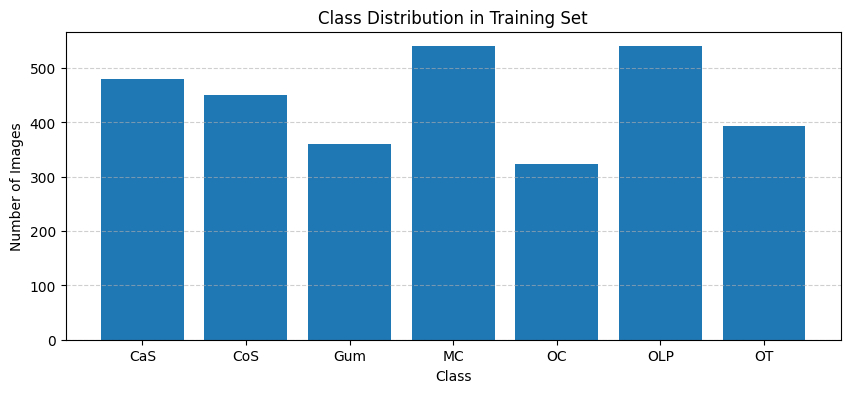

In [6]:
label_counts = Counter(train_labels)
plt.figure(figsize=(10, 4))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [7]:
print(train_images.shape)

(3087, 256, 256, 3)


In [8]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images in loader:
        images = images.float() / 255.0              
        images = images.permute(0, 3, 1, 2)         

        batch_samples = images.size(0)
        total_images_count += batch_samples

        mean += images.mean(dim=[0, 2, 3]) * batch_samples  # mean per channel
        std += images.std(dim=[0, 2, 3]) * batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std


In [9]:
train_loader = DataLoader(train_images, batch_size=32)
val_loader = DataLoader(val_images, batch_size=32)
test_loader = DataLoader(test_images, batch_size=32)

In [10]:
train_mean, train_std = get_mean_std(train_loader)
val_mean, val_std = get_mean_std(val_loader)
test_mean, test_std = get_mean_std(test_loader)


In [11]:
class DentalDataset(Dataset):

    def __init__(self, images, labels, minority_classes, augment_transform, standard_transform):
        self.images = images              
        self.labels = labels             
        self.minority_classes = minority_classes
        self.augment_transform = augment_transform
        self.standard_transform = standard_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):  # Each time the model requests a batch:
                                # __getitem__() is called for each index in the batch
                                # If that sample belongs to a minority class, it goes through augment_transform
                                # Otherwise, it goes through standard_transform
        img = self.images[idx]
        label = self.labels[idx]

       
        if label in self.minority_classes:
            img = self.augment_transform(img)
        else:
            img = self.standard_transform(img)

        return img, label


In [12]:
augment = transforms.Compose([
    transforms.ToPILImage(),  # This converts a NumPy array or Tensor to a PIL Image since most
                              # torchvision.transforms (like RandomRotation, RandomCrop, etc.) only work on PIL images, not raw NumPy arrays.
    transforms.Resize((224, 224)),

    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # Randomly adds or subtracts up to 30% of the brightness, contrast
                                                                                   # and saturation, Randomly shifts the hue (color tone) within ±5%
                                                                                   #  of the hue spectrum.
    
    transforms.RandomHorizontalFlip(), # mirroring
    transforms.RandomRotation(15), # This randomly rotates the image by a value between -15° and +15°
    transforms.ToTensor(),   # scaling the data pixel/255 [0,1]
    transforms.Normalize(train_mean, train_std)  # normalizing the data (pixel-mean)/std
])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(val_mean, val_std) 
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(test_mean, test_std) 
])


In [13]:
def create_Tensor_Data(X,Y,transform):
    X_tensor = torch.stack([transform(img) for img in X])
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    return TensorDataset(X_tensor, Y_tensor)

In [14]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [15]:
minority_classes = ['OC', 'Gum', 'OT', 'CoS', 'CaS']
minority_classes = label_encoder.transform(minority_classes)  
train_dataset = DentalDataset(
    images=train_images,
    labels=train_labels_encoded,
    minority_classes=minority_classes,
    augment_transform=augment,
    standard_transform=train_transform
)
#train_dataset = create_Tensor_Data(train_images, train_labels_encoded, augment)
val_dataset = create_Tensor_Data(val_images, val_labels_encoded, val_transform)
test_dataset = create_Tensor_Data(test_images, test_labels_encoded, test_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

CaS


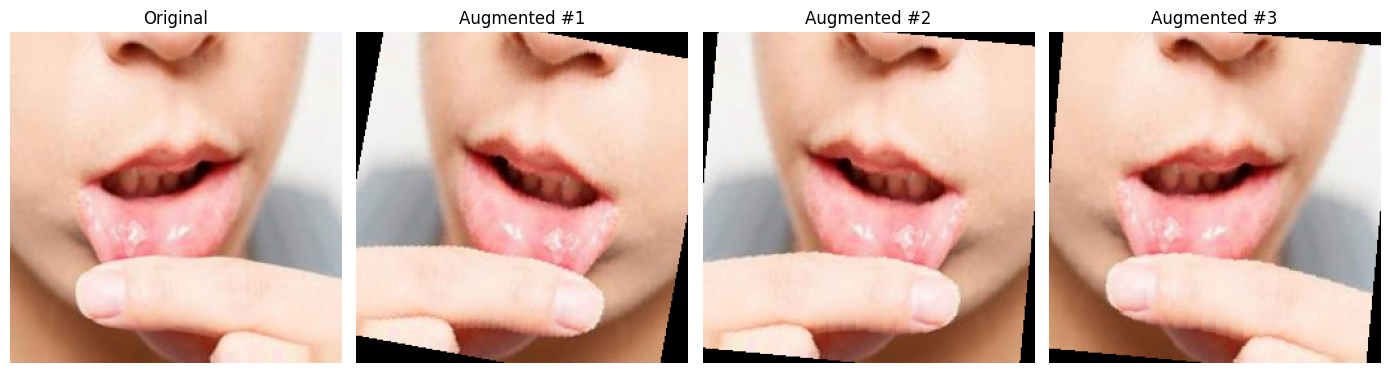

CoS


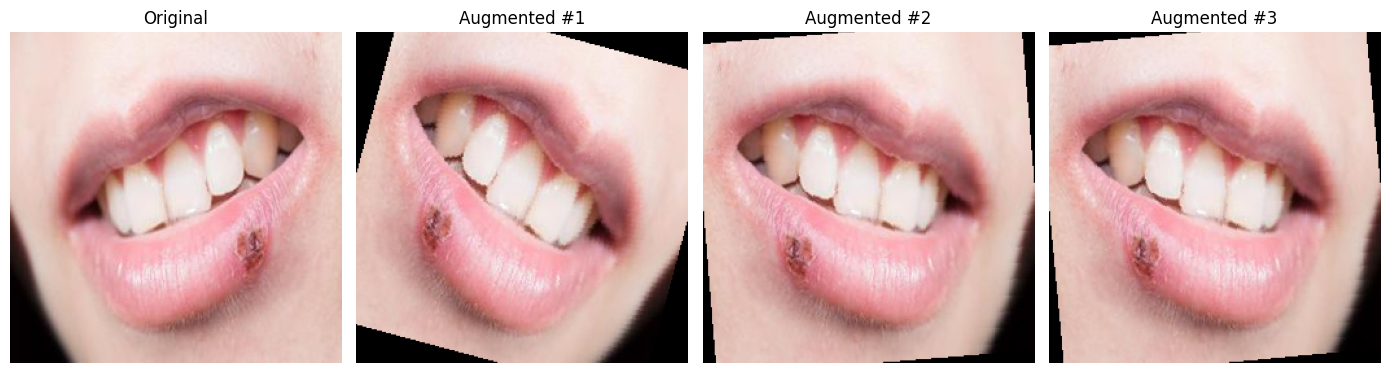

Gum


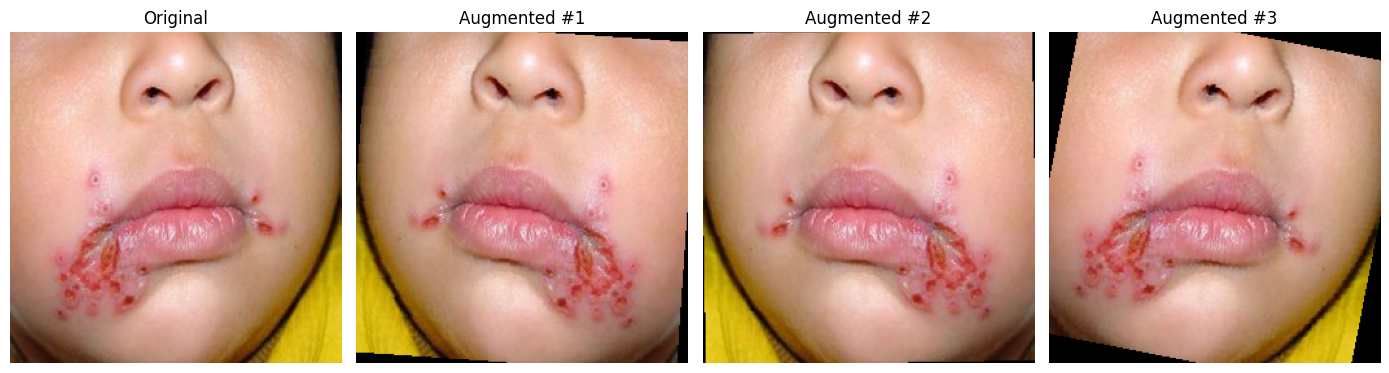

MC


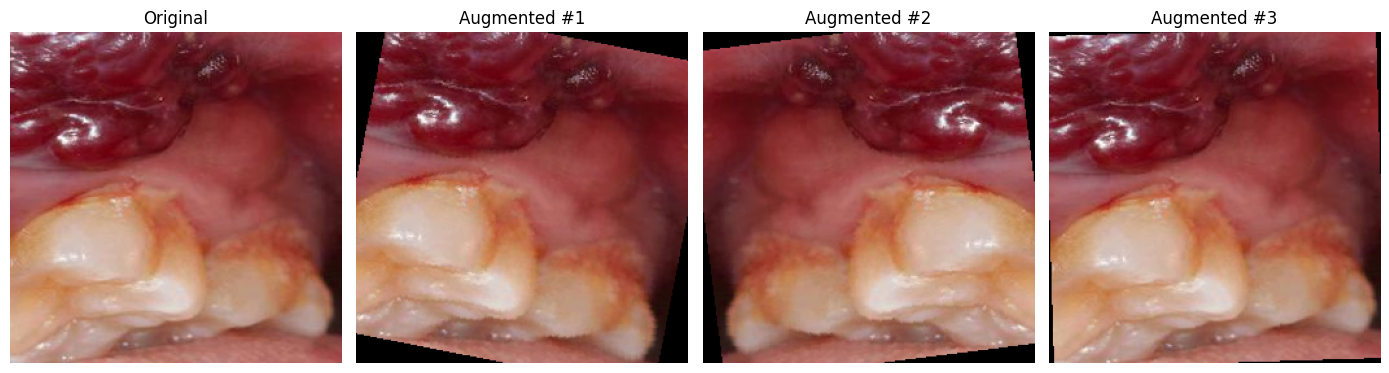

OC


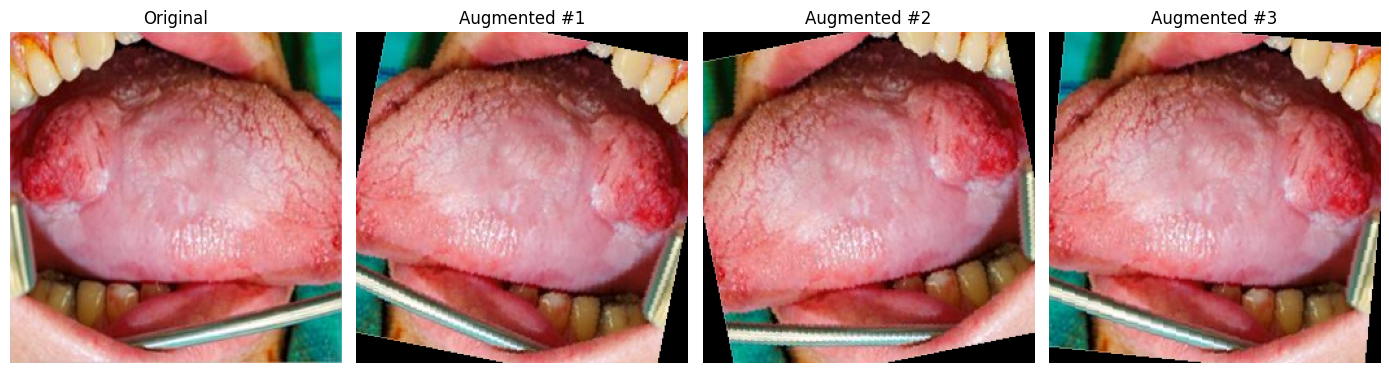

OLP


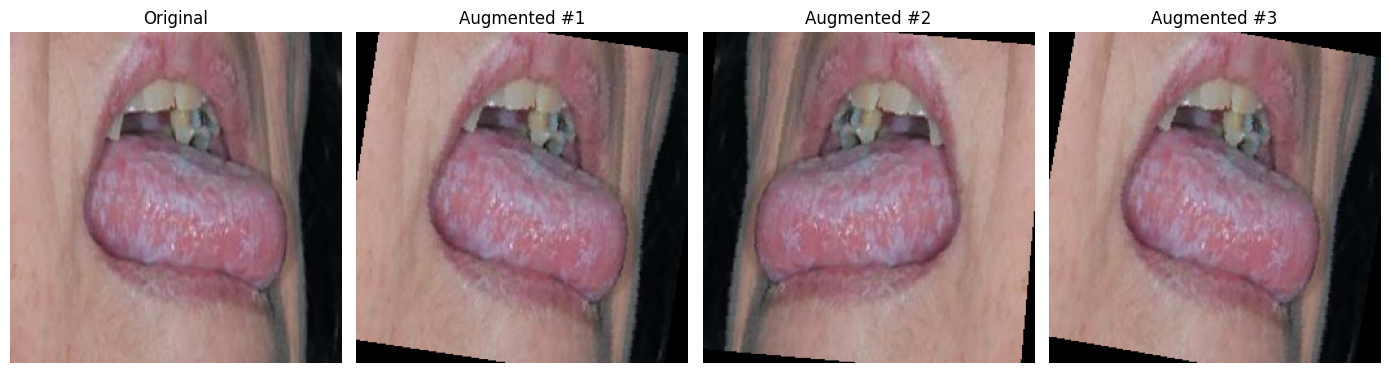

OT


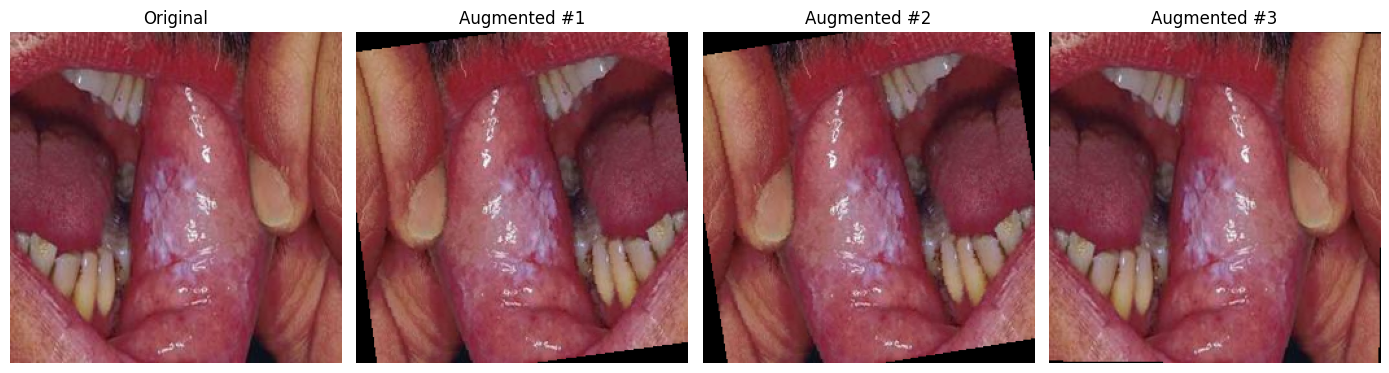

In [16]:
seen_classes = set()
class_images = {}

for img, label in zip(train_images, train_labels):
    if label not in seen_classes:
        class_images[label] = img
        seen_classes.add(label)
    if len(seen_classes) == 7:
        break
        
for label, img in class_images.items():
    unNormalized_augment = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ])
    print(label)
    fig, axes = plt.subplots(1, 4, figsize=(14, 4))

    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i in range(1, 4):
        aug = unNormalized_augment(img).permute(1, 2, 0).numpy()  # After .ToTensor this is the shape (C, H, W).
                                                                   # While this is the shape (H, W, C) imshow can handle so permute is needed tp reorder
        axes[i].imshow(aug)
        axes[i].set_title(f"Augmented #{i}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


## Models

$$
\text{Output size} = \left\lfloor \frac{W - K + 2P}{S} \right\rfloor + 1$$

| Step | Layer                         | Output Shape        | Description                                                    |
|------|-------------------------------|---------------------|----------------------------------------------------------------|
| 0    | **Input**                     | [32, 3, 224, 224]     | Batch of 32 RGB images                           |
| 1    | Conv2d(3 → 8, kernel=5)       | [32, 8, 224, 224]     | 8 filters|
| 2    | MaxPool2d(2×2)                | [32, 8, 112, 112]     | Downsamples each channel by a factor of 2                      |
| 3    | LayerNorm([8, 112, 112])        | [32, 8, 112, 112]     | Applies normalization over each feature map                   |
| 4    | Conv2d(8 → 16, kernel=5)      | [32, 16, 112, 112]      | 16 filters                               |
| 5    | MaxPool2d(2×2)                | [32, 16, 56, 56]      | Downsamples each channel by a factor of 2                      |
| 6    | LayerNorm([16, 61, 61])         | [32, 16, 56, 56]      | Normalizes again after 2nd pooling                            |
| 7    | Flatten                       | [32, 16x56x56]           | Flattens 16x56x56 to feed into fully connected layer             |
| 8    | Linear(16x56x56 → 128)         | [32, 128]            | First fully connected layer with 128 output units               |
| 9   | Dropout                       | [32, 128]            | Randomly zeroes out features (during training)                 |
| 10   | Linear(32 → 7)               | [32, 7]            | Output logits for 7 classes                     |


In [19]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.ln1 = nn.LayerNorm([8, 112, 112])
        self.ln2 = nn.LayerNorm([16, 56, 56])
        self.fc1 = nn.Linear(16*56*56, 128)
        self.ln_fc = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = self.ln1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.ln2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.ln_fc(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


In [20]:
import psutil

mem = psutil.virtual_memory()
print(f"Available: {mem.available / 1e9:.2f} GB, Used: {mem.used / 1e9:.2f} GB")


Available: 1.36 GB, Used: 7.13 GB


In [46]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(12, 24, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(24)

        self.conv3 = nn.Conv2d(24, 48, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)

        self.dropout = nn.Dropout2d(0.6)
        self.fc1 = nn.Linear(48 * 28 * 28, 100)
        self.bn_fc1 = nn.BatchNorm1d(100)

        self.fc2 = nn.Linear(100, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x


## Train data

In [26]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

In [42]:
def train_model(model, train_loader, val_loader, lr, epochs):
    LCE = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad() # preventing accumulation clear the results calculated in the LCE.backward() step 
            output = model(x_batch)
            loss = LCE(output, y_batch)
            loss.backward()
            optimizer.step()    # update weights using the results calculated in the LCE.backward() step
            
            _, predicted = torch.max(output, 1) # return value, index parameters(tensor.vector, dim)
            train_correct += (predicted == y_batch).sum().item() #.item() to convert tensor value to int as (predicted and correct) are tensor values
            
            train_loss += loss.item() * x_batch.size(0) # As the LCE fun. return loss/32 
            total += y_batch.size(0)
            
        train_loss/=total
        train_correct/=total
        train_losses.append(train_loss)
        train_accuracies.append(train_correct)
        
        model.eval() # is a method used to set a PyTorch model to evaluation mode. It affects certain layers in the model that behave differently during training vs. evaluation.
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad(): # This tells PyTorch: “I'm just running the model to get predictions — no need to calculate or store gradients.”
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = LCE(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
    print("\n")
    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch 1/10, Train Loss: 1.7545, Train Acc: 0.3035, Val Loss: 2.2208, Val Acc: 0.2344
Epoch 2/10, Train Loss: 1.3674, Train Acc: 0.4169, Val Loss: 2.9154, Val Acc: 0.2821
Epoch 3/10, Train Loss: 1.1974, Train Acc: 0.5125, Val Loss: 2.6073, Val Acc: 0.3268
Epoch 4/10, Train Loss: 1.1093, Train Acc: 0.5481, Val Loss: 3.1732, Val Acc: 0.2840
Epoch 5/10, Train Loss: 0.9745, Train Acc: 0.6161, Val Loss: 2.9241, Val Acc: 0.2928
Epoch 6/10, Train Loss: 0.8748, Train Acc: 0.6625, Val Loss: 2.9599, Val Acc: 0.3239
Epoch 7/10, Train Loss: 0.8239, Train Acc: 0.6803, Val Loss: 3.2580, Val Acc: 0.3142
Epoch 8/10, Train Loss: 0.7681, Train Acc: 0.7159, Val Loss: 3.0032, Val Acc: 0.3239
Epoch 9/10, Train Loss: 0.6836, Train Acc: 0.7528, Val Loss: 2.8370, Val Acc: 0.3385
Epoch 10/10, Train Loss: 0.6406, Train Acc: 0.7632, Val Loss: 2.7977, Val Acc: 0.3570




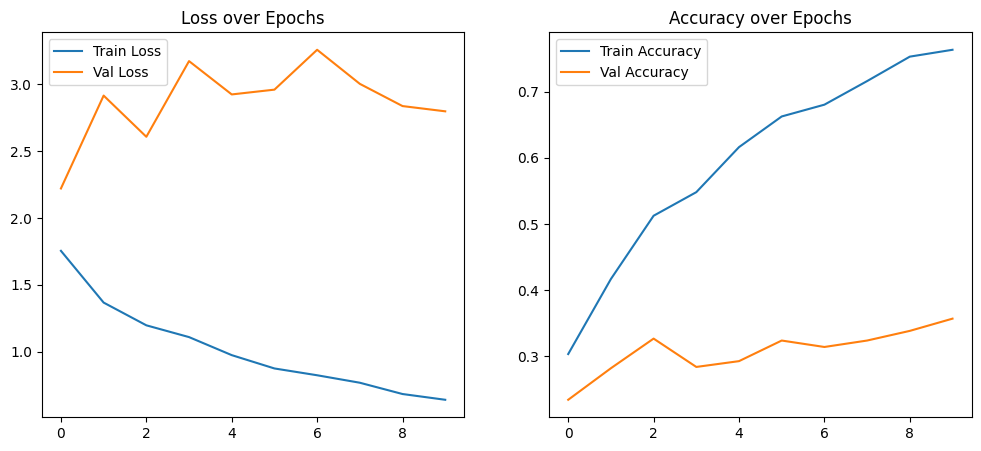

In [28]:
model = CNN1()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.01, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Epoch 1/10, Train Loss: 1.5488, Train Acc: 0.3327, Val Loss: 3.4480, Val Acc: 0.2121
Epoch 2/10, Train Loss: 1.2931, Train Acc: 0.4153, Val Loss: 3.5269, Val Acc: 0.2471
Epoch 3/10, Train Loss: 1.1899, Train Acc: 0.4820, Val Loss: 3.6828, Val Acc: 0.2519
Epoch 4/10, Train Loss: 1.1881, Train Acc: 0.4898, Val Loss: 3.8770, Val Acc: 0.2432
Epoch 5/10, Train Loss: 1.1244, Train Acc: 0.5322, Val Loss: 2.7006, Val Acc: 0.2753
Epoch 6/10, Train Loss: 1.0997, Train Acc: 0.5442, Val Loss: 2.9953, Val Acc: 0.2617
Epoch 7/10, Train Loss: 1.0746, Train Acc: 0.5581, Val Loss: 3.5334, Val Acc: 0.2656
Epoch 8/10, Train Loss: 1.0111, Train Acc: 0.5935, Val Loss: 3.5474, Val Acc: 0.2607
Epoch 9/10, Train Loss: 0.9900, Train Acc: 0.6012, Val Loss: 3.6670, Val Acc: 0.2636
Epoch 10/10, Train Loss: 0.9619, Train Acc: 0.6304, Val Loss: 3.0116, Val Acc: 0.2558




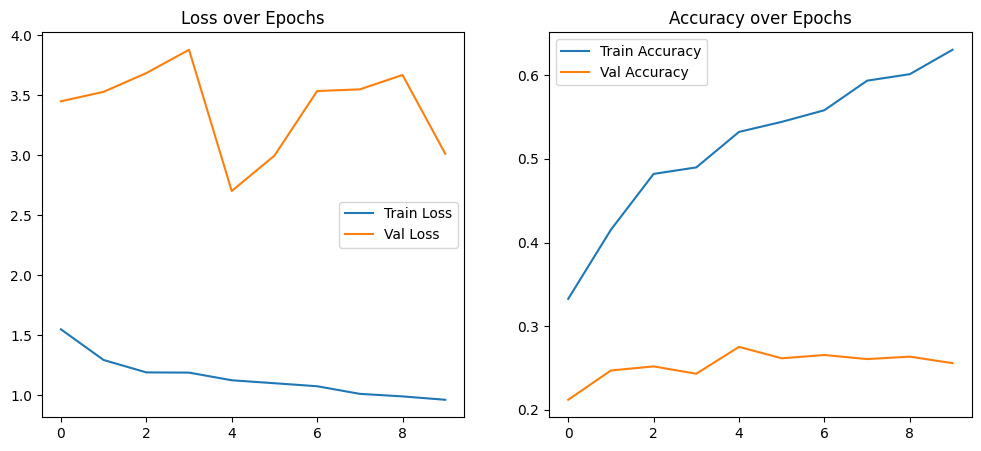

In [51]:
model = CNN2()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.01, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [59]:
test_loader = DataLoader(test_dataset, batch_size=32)

In [61]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {acc:.4f}")
    
    f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro' or 'micro'
    print(f"F1 Score (weighted): {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


In [ ]:
evaluate_model(CNN1(), test_loader)